In [69]:
import numpy as np
import rebound 
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

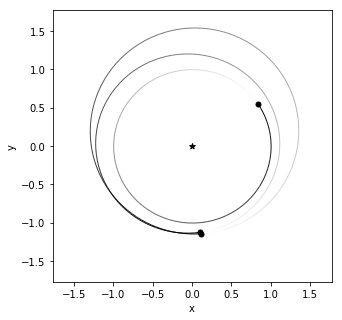

In [23]:
def plot_initial_configuration(num):
    sim = rebound.Simulation.from_file("../../csvs/Sys_2364_1e8/final_conditions/fc{:07d}.bin".format(num))
    rebound.OrbitPlot(sim)
plot_initial_configuration(0)

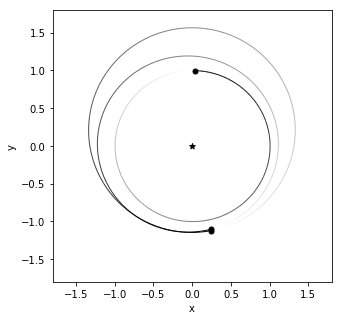

In [24]:
plot_initial_configuration(1)

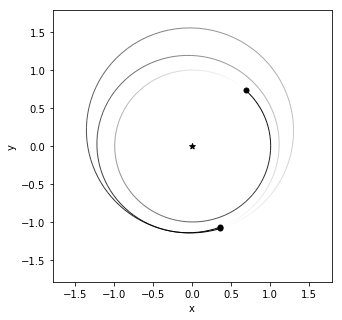

In [25]:
plot_initial_configuration(2)

In [26]:
#reintegrate some test systems, an
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0


In [27]:
import time
from collections import OrderedDict

In [84]:
def generate_features(sim):
    t0 = time.time()
    ps = sim.particles


    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate

    sim.collision_resolve = collision

    #kicksize=1.e-11
    #sim2.particles[2].x += kicksize

    E0 = sim.calculate_energy()
    times = np.linspace(0,tmax,Nout)

    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    print e.shape, "eccentricty"
    inc = np.zeros((sim.N,Nout))

    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)

    eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
    daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]
    final_time = 0
    for i, t in enumerate(times):
        for j in [1,2,3]:
            a[j,i] = ps[j].a
            e[j,i] = ps[j].e
            inc[j,i] = ps[j].inc
        #print("int time", t)
        try:
            sim.integrate(t)
        except:
            print "finished at ", t
            final_time = t
            break

    features = OrderedDict()
    features['t_final_short'] = sim.t/P0
    Ef = sim.calculate_energy()
    features['Rel_Eerr_short'] = abs((Ef-E0)/E0)
    #print e
    for j in [1,2,3]:
        for string, feature in [('a', a), ('e', e), ('inc', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()
            features['avg_'+string+str(j)] = mean
            features['std_'+string+str(j)] = std
            features['max_'+string+str(j)] = feature[j].max()
            features['min_'+string+str(j)] = feature[j].min()
            features['norm_std_'+string+str(j)] = std/mean
            features['norm_max_'+string+str(j)] = np.abs(feature[j] - mean).max()/mean
            sample = feature[j][:window]
            samplemean = sample.mean()
            features['norm_std_window'+str(window)+'_'+string+str(j)] = sample.std()/samplemean
            features['norm_max_window'+str(window)+'_'+string+str(j)] = np.abs(sample - samplemean).max()/samplemean

        for string, feature in [('eH', e), ('iH', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()

            features['avg_'+string+str(j)] = mean/eHill[j]
            features['std_'+string+str(j)] = std/eHill[j]
            features['max_'+string+str(j)] = feature[j].max()/eHill[j]
            features['min_'+string+str(j)] = feature[j].min()/eHill[j]

        string, feature = ('ecross', e)
        features['avg_'+string+str(j)] = mean/daOvera[j]
        features['std_'+string+str(j)] = std/daOvera[j]
        features['max_'+string+str(j)] = feature[j].max()/daOvera[j]
        features['min_'+string+str(j)] = feature[j].min()/daOvera[j]

        xx = range(a[j].shape[0])
        yy = a[j]/a[j].mean()/features["t_final_short"]
        par = np.polyfit(xx, yy, 1, full=True)
        features['norm_a'+str(j)+'_slope'] = par[0][0]

    t = time.time()
    features['wall_time'] = t-t0
    return pd.Series(features, index=list(features.keys())), e, final_time


(4, 200) eccentricty
finished at  64321.585406085454


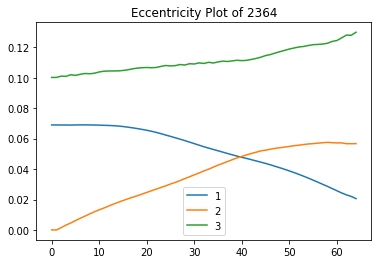

In [112]:
def plot_e (num, sys_id):
    plt.figure()
    plt.title("Eccentricity Plot of {0}".format(sys_id))
    sim = rebound.Simulation.from_file("../../csvs/Sys_{1}_1e8/initial_conditions/ic{0:07d}.bin".format(num, sys_id))
    maxorbs= 2e5
    Nout = 200
    window = 10
    values, eccen, final_time= generate_features(sim)
    e_1 = np.trim_zeros(eccen[1, :])
    e_2 = np.trim_zeros(eccen[2, :])
    e_3 = np.trim_zeros(eccen[3, :])
    plt.plot(e_1, label = "1")
    plt.plot(e_2, label = "2")
    plt.plot(e_3, label = "3")
    plt.legend()
    #multiply x axis by 1000 for it to correspond to number of orbits
plot_e(2, 2364)

(4, 200) eccentricty
finished at  87437.15516139742
(4, 200) eccentricty
finished at  62311.53586214528
(4, 200) eccentricty
finished at  64321.585406085454
(4, 200) eccentricty
finished at  64321.585406085454
(4, 200) eccentricty
finished at  63316.56063411537


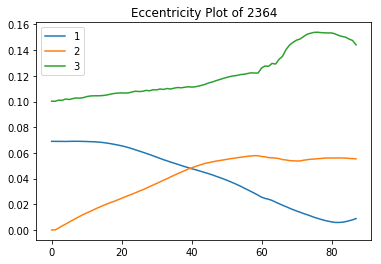

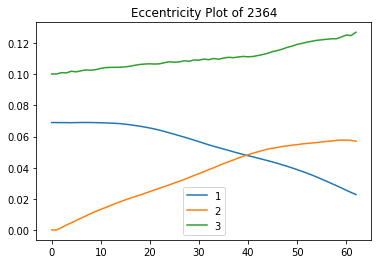

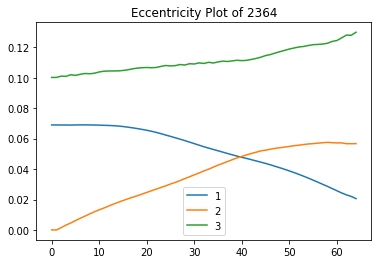

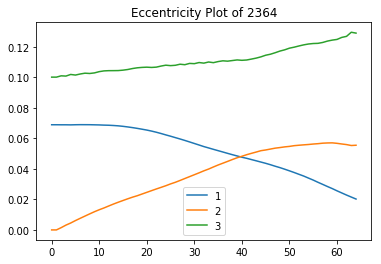

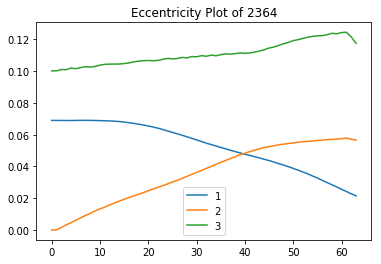

In [113]:
for i in range(5):
    plot_e(i, 2364)

In [114]:
def generate_features_e_and_pomega(sim):
    t0 = time.time()
    ps = sim.particles


    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate

    sim.collision_resolve = collision

    #kicksize=1.e-11
    #sim2.particles[2].x += kicksize

    E0 = sim.calculate_energy()
    times = np.linspace(0,tmax,Nout)

    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    print e.shape, "eccentricty"
    inc = np.zeros((sim.N,Nout))

    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)

    eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
    daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]
    final_time = 0
    for i, t in enumerate(times):
        for j in [1,2, 3]:
            e[j,i] = ps[j].e
            inc[j,i] = ps[j].pomega
        #print("int time", t)
        try:
            sim.integrate(t)
        except:
            print "finished at ", t
            final_time = t
            break

    features = OrderedDict()
    features['t_final_short'] = sim.t/P0
    Ef = sim.calculate_energy()
    features['Rel_Eerr_short'] = abs((Ef-E0)/E0)
   
     
    t = time.time()
    features['wall_time'] = t-t0
    return pd.Series(features, index=list(features.keys())), e, final_time, inc


(4, 200) eccentricty
finished at  87437.15516139742
(4, 200) eccentricty
finished at  64321.585406085454


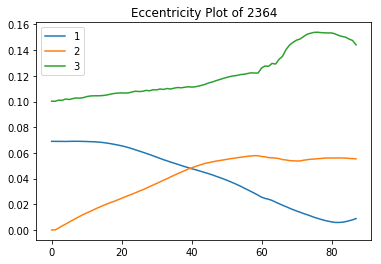

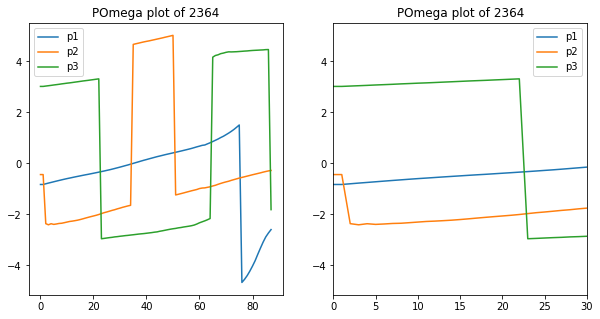

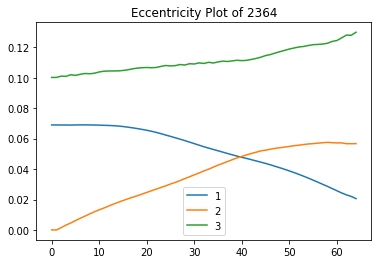

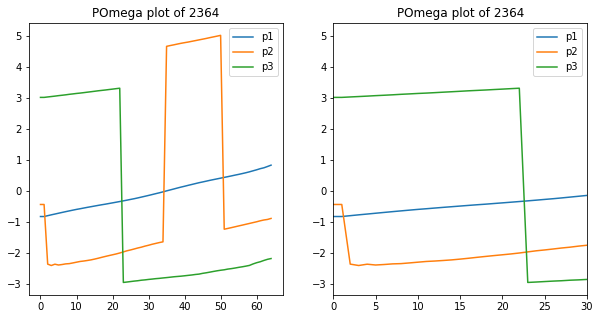

In [124]:
def plot_e_and_pomega (num, sys_id):
    plt.figure()
    #sim = rebound.Simulation.from_file(file_path + "{:07d}.bin".format(num))
    plt.title("Eccentricity Plot of {0}".format(sys_id))
    sim = rebound.Simulation.from_file("../../csvs/Sys_{1}_1e8/initial_conditions/ic{0:07d}.bin".format(num, sys_id))
   
    maxorbs= 2e5
    Nout = 200
    window = 10
    values, eccen, final_time, pomega= generate_features_e_and_pomega(sim)
    e_1 = np.trim_zeros(eccen[1, :])
    e_2 = np.trim_zeros(eccen[2, :])
    e_3 = np.trim_zeros(eccen[3, :])
    p_1 = np.trim_zeros(pomega[1, :])
    p_2 = np.trim_zeros(pomega[2, :])
    p_3 = np.trim_zeros(pomega[3, :])
    plt.plot(e_1, label = "1")
    plt.plot(e_2, label = "2")
    plt.plot(e_3, label = "3")
    plt.legend()
    fig =  plt.figure(figsize=(10,5))
    ax = fig.add_subplot("121")
    ax.set_title("POmega plot of {0}".format(sys_id))
    ax.plot(p_1, label = "p1")
    ax.plot(p_2, label = "p2")
    ax.plot(p_3, label = "p3")
    ax.legend()
    
    ax1 = fig.add_subplot("122")
    ax1.set_title("POmega plot of {0}".format(sys_id))
    ax1.plot(p_1, label = "p1")
    ax1.plot(p_2, label = "p2")
    ax1.plot(p_3, label = "p3")
    ax1.set_xlim([0,30])
    ax1.legend()
    
    #multiply x axis by 1000 for it to correspond to number of orbits
plot_e_and_pomega(0,2364)
plot_e_and_pomega(2,2364)

(4, 200) eccentricty
finished at  28140.682259518013
(4, 200) eccentricty
finished at  27135.657893106654
(4, 200) eccentricty
finished at  23115.572612695025
(4, 200) eccentricty
finished at  23115.572612695025


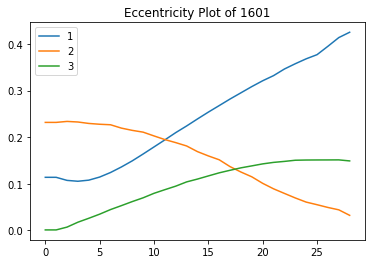

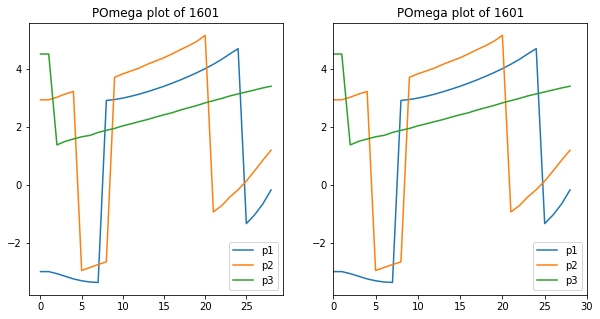

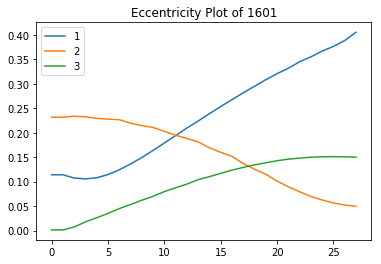

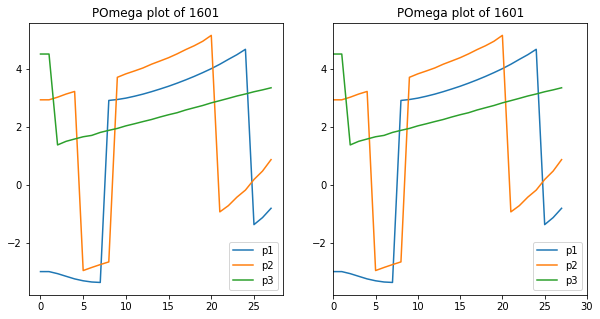

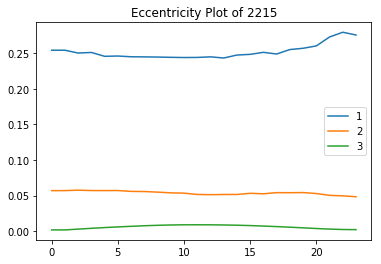

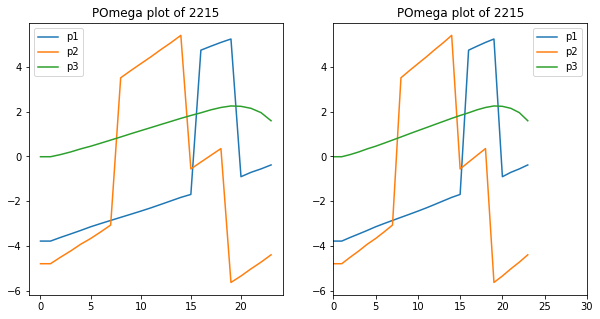

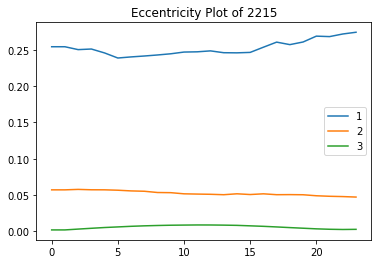

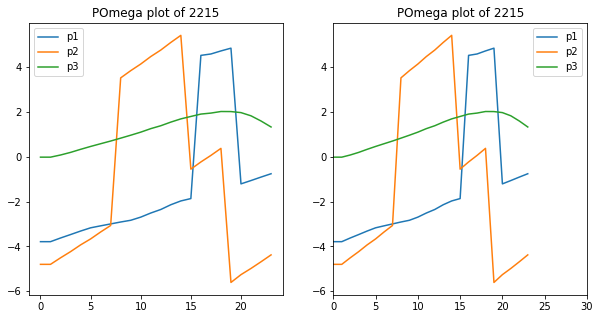

In [125]:
#look at the other two very peaked distributions
plot_e_and_pomega(0,1601)
plot_e_and_pomega(2, 1601)

plot_e_and_pomega(0,2215)
plot_e_and_pomega(2,2215)

(4, 200) eccentricty
finished at  156781.1688126079
(4, 200) eccentricty


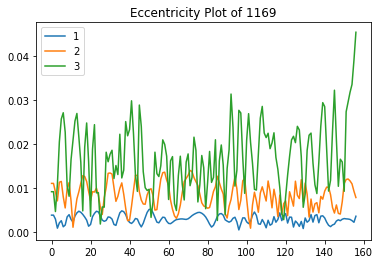

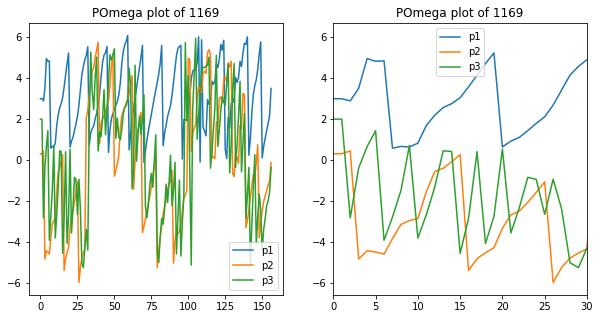

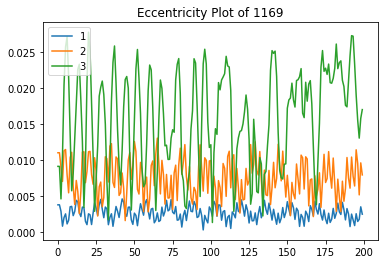

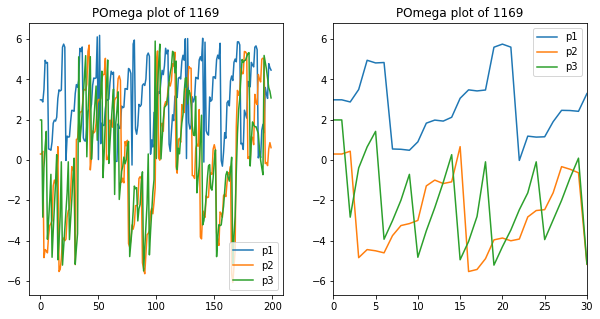

In [126]:
#look at the three very gaussian systems
plot_e_and_pomega(0,1169)
plot_e_and_pomega(2,1169)

(4, 200) eccentricty
(4, 200) eccentricty


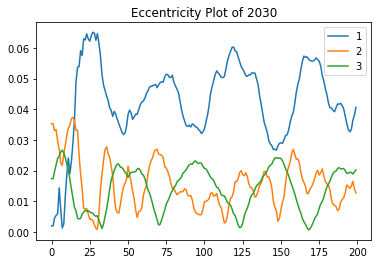

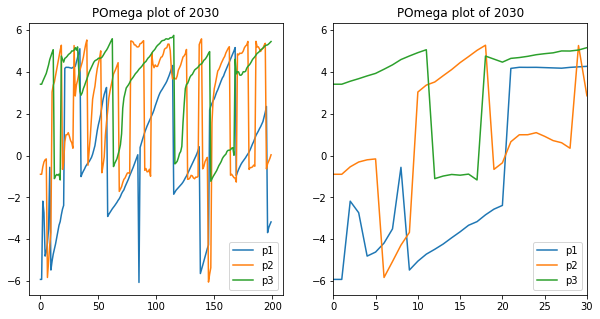

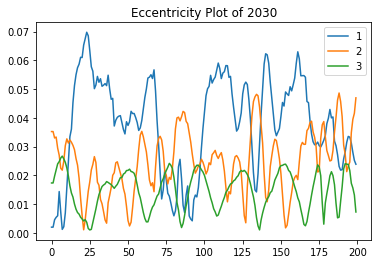

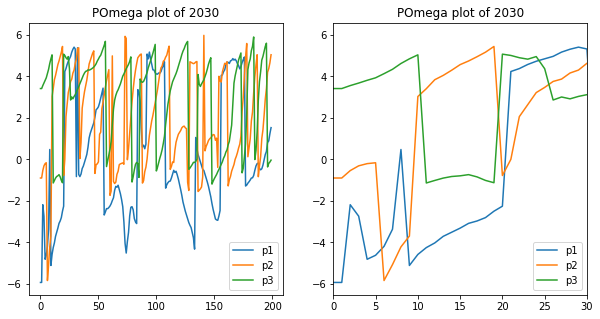

In [127]:
plot_e_and_pomega(0,2030)
plot_e_and_pomega(2, 2030)

(4, 200) eccentricty
finished at  63316.54012145395
(4, 200) eccentricty
finished at  126633.0802429079


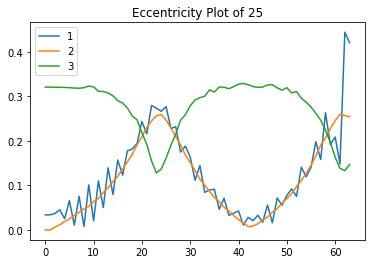

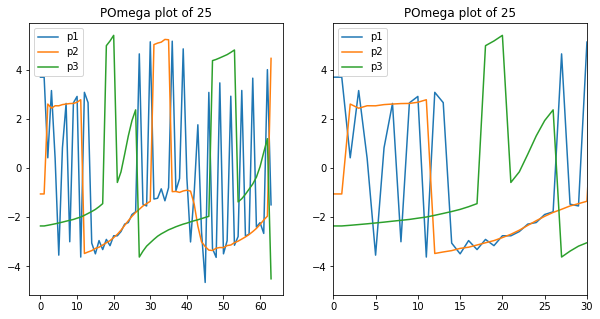

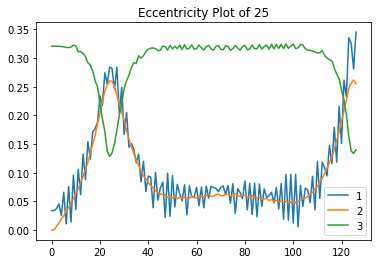

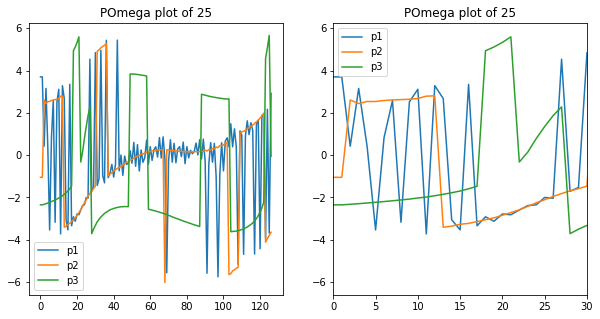

In [128]:
plot_e_and_pomega(0,25)
plot_e_and_pomega(2, 25)